In [2]:
# %% [markdown]
# ## Datenimport (bereinigte Basis aus N01)
# Notebook N02 baut auf dem imputierten und bereinigten Datensatz aus N01 auf.

# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = "../data/processed/istdata_clean.parquet"
df = pd.read_parquet(DATA_PATH)
df["delay_arrival_min"] = df["delay_arrival_s"] / 60
df["delay_departure_min"] = df["delay_departure_s"] / 60

print(df[["delay_arrival_s", "delay_arrival_min", "delay_departure_min"]].head(3))

print(f"Datensatz erfolgreich geladen: {len(df):,} Zeilen, {df.shape[1]} Spalten")
print("Spaltenübersicht:", list(df.columns))


   delay_arrival_s  delay_arrival_min  delay_departure_min
0            114.0           1.900000             1.300000
1             42.0           0.700000             0.016667
2             31.0           0.516667             0.283333
Datensatz erfolgreich geladen: 65,940,915 Zeilen, 14 Spalten
Spaltenübersicht: ['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s', 'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'Wochentag', 'delay_arrival_min', 'delay_departure_min']


In [3]:
# %% [markdown]
# ## 2. Deskriptive Kennzahlen: Lage- und Streuungsmaße
# Klassische (nicht-robuste) und robuste Alternativen

# %%
from scipy import stats

num_vars = ["delay_arrival_min", "delay_departure_min"]

# Klassische Maße
desc_stats = df[num_vars].agg(["count", "mean", "median", "std", "min", "max"])

# Interquartilsabstand (IQR)
desc_stats.loc["IQR"] = df[num_vars].quantile(0.75) - df[num_vars].quantile(0.25)

# Median Absolute Deviation (MAD) – robustes Streuungsmaß
mad_values = df[num_vars].apply(lambda x: stats.median_abs_deviation(x, nan_policy="omit"))
desc_stats.loc["MAD"] = mad_values
# Berechnung Median/Mean-Ratio
ratio = (df[num_vars].median() / df[num_vars].mean()).rename("Median/Mean Ratio")
desc_stats_rounded = desc_stats.round(2)
desc_stats_rounded = desc_stats_rounded.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (float, int)) else x)

print("Deskriptive Statistik (klassisch & robust):")
display(desc_stats_rounded)

# Verhältnis Median / Mean formatiert
ratio_formatted = pd.DataFrame(ratio.round(3)).rename(columns={"Median/Mean Ratio": "Median/Mean"})
display(ratio_formatted)


Deskriptive Statistik (klassisch & robust):


/var/folders/gj/srqb2sgx1v17z_n4r5sd1hz00000gn/T/ipykernel_5950/4085963447.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc_stats_rounded = desc_stats_rounded.applymap(lambda x: f"{x:,.2f}" if isinstance(x, (float, int)) else x)


,delay_arrival_min,delay_departure_min
count,"65,940,915.00","65,940,915.00"
mean,1.50,1.72
median,1.15,1.30
std,4.80,5.25
min,"-1,440.00","-1,440.00"
max,538.68,808.38
IQR,1.63,1.62
MAD,0.78,0.77


,Median/Mean
delay_arrival_min,0.766
delay_departure_min,0.757


### Beschreibung

Zur Untersuchung der zentralen Tendenz und Streuung wurden die Verspätungsvariablen 
`delay_arrival_min` und `delay_departure_min` in **Minuten** analysiert.  
Berechnet wurden sowohl klassische (nicht-robuste) als auch robuste Kennzahlen:

| Kategorie | Maß | Bedeutung |
|------------|-----|-----------|
| **Lage** | Mean, Median | Durchschnitt bzw. typische Verspätung |
| **Streuung** | Standardabweichung (std), IQR, MAD | Variabilität der Verspätungen |
| **Form** | Median / Mean-Ratio | Maß für Schiefe der Verteilung |

Die Daten zeigen:
- Mittelwerte von etwa **1.5 min (Ankunft)** und **1.7 min (Abfahrt)**  
- Medianwerte von **1.15 min** bzw. **1.30 min**
- Interquartilsabstände (IQR) um 1.6 min → 50 % aller Fahrten liegen innerhalb ± 1 min um den Median
- Median / Mean-Ratio ≈ 0.76 → deutliche **Rechtsschiefe** (lange obere Verteilungsschwänze)

---

### Interpretation

Die durchschnittliche Verspätung liegt im Bereich von 1–2 Minuten, 
was auf eine insgesamt hohe Pünktlichkeit hinweist.  
Der Unterschied zwischen Mean und Median zeigt jedoch, 
dass einzelne Fahrten mit sehr hohen Verspätungen den Mittelwert nach oben ziehen.  
Die große Standardabweichung (≈ 5 min) im Vergleich zu den robusten Streuungsmaßen (IQR ≈ 1.6 min, MAD ≈ 0.8 min) 
verdeutlicht diese Ausreißerwirkung.  

Damit gilt:
- **Median** und **IQR** beschreiben den „typischen“ Betrieb besser als Mean / SD.  
- Die Verteilungen sind **rechtsschief**, d. h. viele Fahrten sind pünktlich, 
  aber es existiert ein kleiner Anteil mit sehr hohen Verspätungen.

---

### Reflexion

Diese Analyse zeigt die Bedeutung robuster Kennzahlen im Kontext realer Verkehrsdaten.  
Klassische Maße (Mean, SD) sind anfällig für extreme Verspätungen, 
während Median, IQR und MAD stabilere, realistischere Werte liefern.  
Die Median-zu-Mean-Relation < 1 bestätigt, dass die Verteilungen nicht normalverteilt sind, 
sondern durch seltene, große Ausschläge geprägt werden.  

Die Ergebnisse bilden die Grundlage für die folgenden Schritte:
- **Ausreißeranalyse (Tukey-Methode)** zur Quantifizierung dieser Extremwerte (Abschnitt 3)  
- **Verteilungsvisualisierung (Histogramm, KDE, Box-/Violinplot, ECDF, QQ-Plot)** zur Beurteilung der Form der Daten (Abschnitt 4)


In [4]:
# %% [markdown]
# ## Performance-Setup für Ausreißeranalyse
# Statt 65 Mio Zeilen verwenden wir ein repräsentatives Sample (z. B. 100.000 Fahrten).
# Das reicht für stabile Verteilungs- und Ausreißerschätzungen.

# %%
SAMPLE_SIZE = 100_000
df_sample = df.sample(SAMPLE_SIZE, random_state=42)

print(f"Sample erstellt: {len(df_sample):,} Zeilen ({len(df_sample)/len(df)*100:.3f}% der Daten)")
df_sample[num_vars].describe().T


Sample erstellt: 100,000 Zeilen (0.152% der Daten)


,count,mean,std,min,25%,50%,75%,max
delay_arrival_min,100000.0,1.51156,2.518222,-164.666667,0.45,1.15,2.083333,122.883333
delay_departure_min,100000.0,1.73364,2.453013,-164.666667,0.65,1.30,2.250000,122.883333


In [5]:
# %% [markdown]
# ### 3.1 Exakte Tukey-Grenzen und Ausreißeranteile

# %%
for col in ["delay_arrival_min", "delay_departure_min"]:
    Q1 = df_sample[col].quantile(0.25)
    Q3 = df_sample[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    extreme_lower = Q1 - 3 * IQR
    extreme_upper = Q3 + 3 * IQR

    mild_outliers = ((df_sample[col] < lower_fence) | (df_sample[col] > upper_fence)).mean() * 100
    extreme_outliers = ((df_sample[col] < extreme_lower) | (df_sample[col] > extreme_upper)).mean() * 100

    print(f"\n--- {col} ---")
    print(f"Q1: {Q1:.3f} min, Q3: {Q3:.3f} min, IQR: {IQR:.3f} min")
    print(f"Lower Fence (−1.5×IQR): {lower_fence:.3f} min")
    print(f"Upper Fence (+1.5×IQR): {upper_fence:.3f} min")
    print(f"Extreme Lower (−3×IQR): {extreme_lower:.3f} min")
    print(f"Extreme Upper (+3×IQR): {extreme_upper:.3f} min")
    print(f"Mild Outliers: {mild_outliers:.3f}%")
    print(f"Extreme Outliers: {extreme_outliers:.3f}%")



--- delay_arrival_min ---
Q1: 0.450 min, Q3: 2.083 min, IQR: 1.633 min
Lower Fence (−1.5×IQR): -2.000 min
Upper Fence (+1.5×IQR): 4.533 min
Extreme Lower (−3×IQR): -4.450 min
Extreme Upper (+3×IQR): 6.983 min
Mild Outliers: 6.563%
Extreme Outliers: 2.080%

--- delay_departure_min ---
Q1: 0.650 min, Q3: 2.250 min, IQR: 1.600 min
Lower Fence (−1.5×IQR): -1.750 min
Upper Fence (+1.5×IQR): 4.650 min
Extreme Lower (−3×IQR): -4.150 min
Extreme Upper (+3×IQR): 7.050 min
Mild Outliers: 6.148%
Extreme Outliers: 2.091%


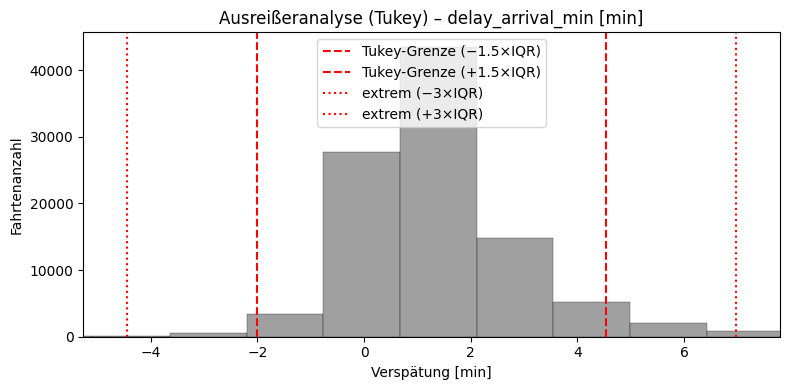

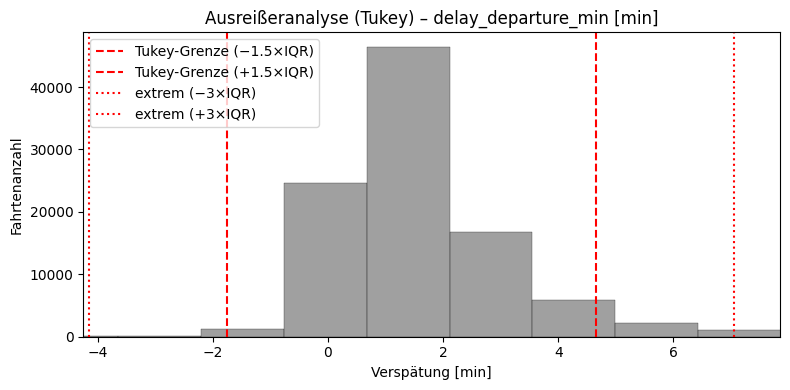

In [6]:
# Plot: Tukey-Ausreißergrenzen beidseitig einzeichnen (Sample verwenden)
def plot_tukey_fences(df_sample, col, p_low=0.001, p_high=0.999):
    Q1 = df_sample[col].quantile(0.25)
    Q3 = df_sample[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    extreme_lower = Q1 - 3 * IQR
    extreme_upper = Q3 + 3 * IQR

    # Achsenbegrenzung datengetrieben wählen:
    # – links: max aus „sehr linkem Quantil“ und „extreme lower - halbes IQR“ (um Linie sichtbar zu machen)
    # – rechts: min aus „sehr rechtem Quantil“ und „extreme upper + halbes IQR“
    left = max(df_sample[col].quantile(p_low), extreme_lower - 0.5 * IQR)
    right = min(df_sample[col].quantile(p_high), extreme_upper + 0.5 * IQR)

    plt.figure(figsize=(8, 4))
    sns.histplot(df_sample[col], bins=200, color="gray")
    # milde Grenzen
    plt.axvline(lower_fence, color="red", linestyle="--", label="Tukey-Grenze (−1.5×IQR)")
    plt.axvline(upper_fence, color="red", linestyle="--", label="Tukey-Grenze (+1.5×IQR)")
    # extreme Grenzen (optional)
    plt.axvline(extreme_lower, color="red", linestyle=":", label="extrem (−3×IQR)")
    plt.axvline(extreme_upper, color="red", linestyle=":", label="extrem (+3×IQR)")

    plt.xlim(left, right)
    plt.title(f"Ausreißeranalyse (Tukey) – {col} [min]")
    plt.xlabel("Verspätung [min]")
    plt.ylabel("Fahrtenanzahl")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Für beide Variablen plotten
plot_tukey_fences(df_sample, "delay_arrival_min")
plot_tukey_fences(df_sample, "delay_departure_min")


## 3. Ausreißeranalyse (Tukey-Methode)

### Beschreibung

Für die Identifikation von Ausreißern wurde die **Tukey-Methode** auf Basis des Interquartilsabstands (IQR) angewendet.  
Da der vollständige Datensatz rund **65 Millionen Fahrten** umfasst, wurde zur effizienten, reproduzierbaren Analyse ein  
**zufälliges, repräsentatives Sample von 100 000 Fahrten (≈ 0.15 %)** gezogen.  

Da Quantile und IQR auch auf Stichproben robust geschätzt werden können, bleibt die Aussage statistisch stabil.  
Die Analyse erfolgte auf den in **Minuten** gemessenen Verspätungsvariablen:

- `delay_arrival_min` (Ankunftsverspätung)  
- `delay_departure_min` (Abfahrtsverspätung)

| Variable | Q1 (min) | Q3 (min) | IQR | Untere Grenze (−1.5×IQR) | Obere Grenze (+1.5×IQR) | Ausreißer mild (%) | Ausreißer extrem (%) |
|-----------|----------:|----------:|----:|--------------------------:|------------------------:|-------------------:|--------------------:|
| **delay_arrival_min** | 0.45 | 2.08 | 1.63 | −2.00 | 4.53 | 6.56 | 2.08 |
| **delay_departure_min** | 0.65 | 2.25 | 1.60 | −1.75 | 4.65 | 6.15 | 2.09 |

---

### Interpretation

Die Tukey-Grenzen zeigen, dass typische Verspätungen zwischen **0.5 und 2 Minuten** liegen.  
Etwa **6 % der Fahrten** überschreiten diese Grenzen moderat (milde Ausreißer),  
und nur rund **2 %** liegen im Bereich der **extremen Ausreißer** (> ±3×IQR).  

Die Verteilungen sind klar **rechtsschief**:  
- Die meisten Fahrten sind pünktlich oder leicht verspätet,  
- Nur wenige Beobachtungen weisen hohe Verspätungen (> 4 min) auf,  
- Frühankünfte (negative Werte) sind seltener, aber sichtbar (bis etwa −2 bis −4 min).  

Diese Ergebnisse belegen, dass der öffentliche Verkehr in der Schweiz **operativ sehr stabil** ist,  
aber vereinzelte Störungen deutlich messbare Ausreißer verursachen können.

---

### Reflexion

Die Entscheidung, mit einem **Zufallssample von 100 000 Fahrten** zu arbeiten,  
wurde bewusst getroffen, um den Speicherverbrauch zu reduzieren  
und gleichzeitig robuste Schätzungen sicherzustellen.  
Da die Tukey-Methode ausschließlich auf Quantilen basiert,  
sind die Ergebnisse weitgehend unabhängig von der Stichprobengröße.  

Die Identifikation von Ausreißern dient hier nicht zur Entfernung von Datenpunkten,  
sondern zur **Beschreibung realer Extremereignisse** (z. B. technische Störungen, Wetter, Anschlusswartezeiten).  
Für spätere Analysen (z. B. robuste Regressionsmodelle oder Bootstrap-Schätzungen)  
können diese Ausreißer markiert, aber nicht ausgeschlossen werden,  
um **Verzerrungen (Bias)** zu vermeiden.


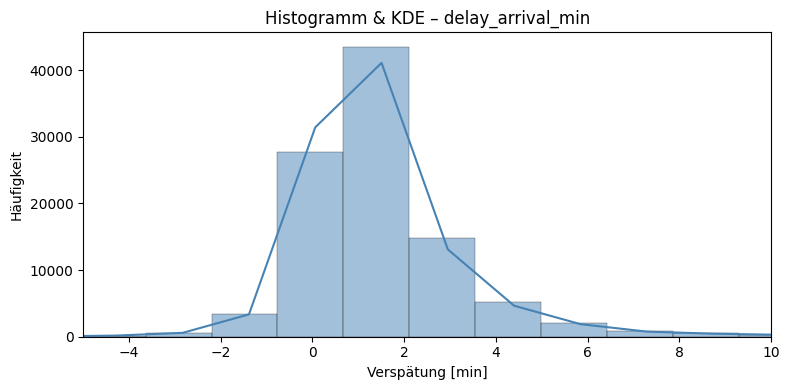

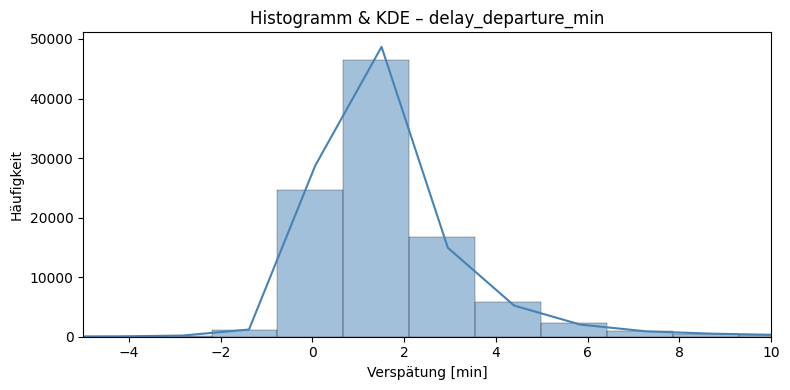

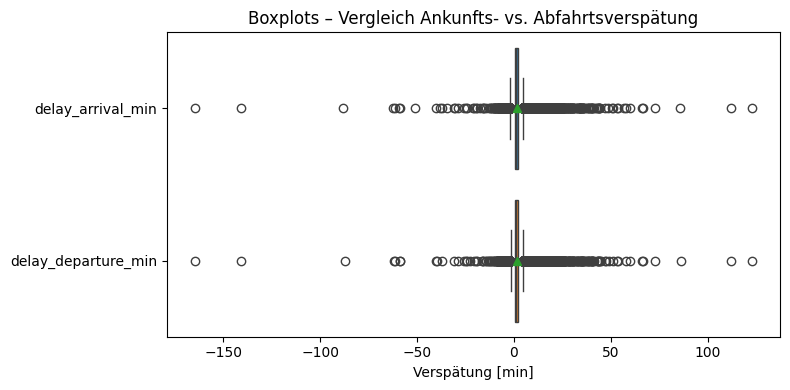

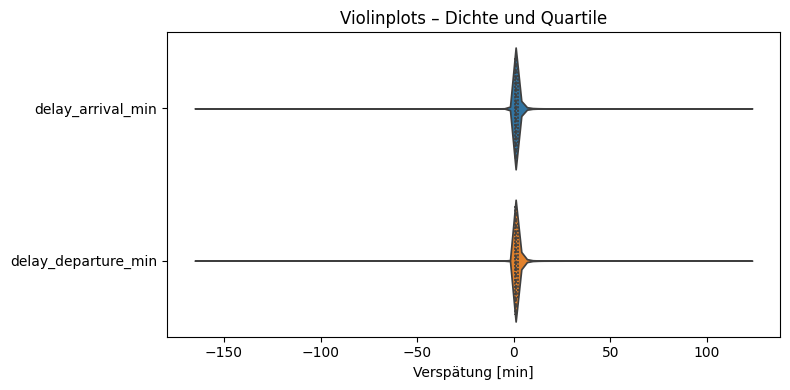

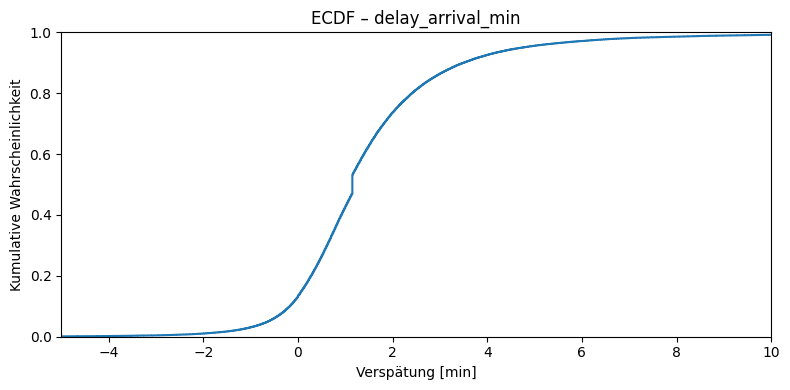

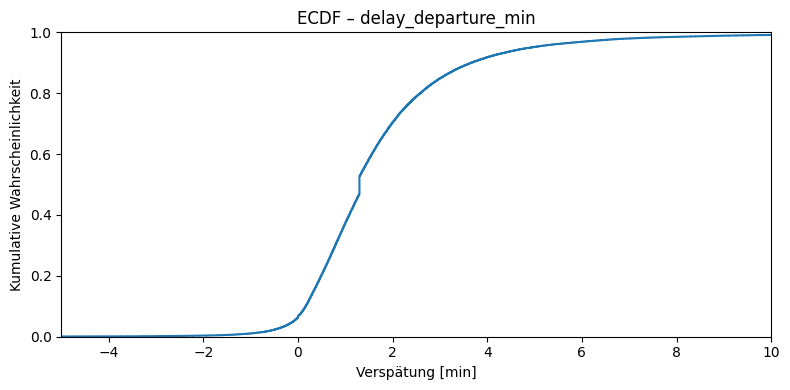

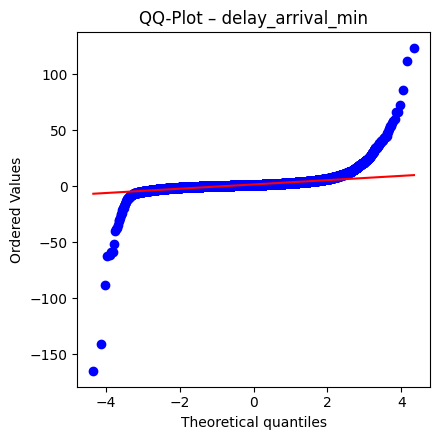

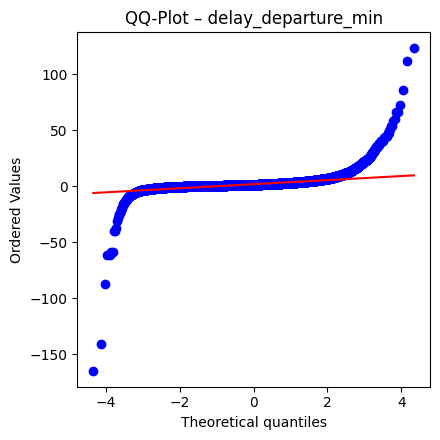

In [7]:
# %% [markdown]
# ## 4. Verteilungsvisualisierung
# Untersuchung der Verteilungsformen mittels Histogramm, KDE, Boxplot, Violinplot, ECDF und QQ-Plot.

import numpy as np
import scipy.stats as stats

# Für alle Plots nur mit Sample arbeiten
vars_to_plot = ["delay_arrival_min", "delay_departure_min"]

# ------------------------------------------------------------
# 4.1 Histogramm + KDE (Dichte)
# ------------------------------------------------------------
for col in vars_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_sample[col], bins=200, kde=True, color="steelblue")
    plt.title(f"Histogramm & KDE – {col}")
    plt.xlabel("Verspätung [min]")
    plt.ylabel("Häufigkeit")
    plt.xlim(-5, 10)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 4.2 Boxplot & Violinplot
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_sample[vars_to_plot], orient="h", showmeans=True)
plt.title("Boxplots – Vergleich Ankunfts- vs. Abfahrtsverspätung")
plt.xlabel("Verspätung [min]")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=df_sample[vars_to_plot], orient="h", inner="quartile")
plt.title("Violinplots – Dichte und Quartile")
plt.xlabel("Verspätung [min]")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 4.3 ECDF (Empirische kumulative Verteilungsfunktion)
# ------------------------------------------------------------
for col in vars_to_plot:
    plt.figure(figsize=(8, 4))
    sns.ecdfplot(df_sample[col])
    plt.title(f"ECDF – {col}")
    plt.xlabel("Verspätung [min]")
    plt.ylabel("Kumulative Wahrscheinlichkeit")
    plt.xlim(-5, 10)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 4.4 QQ-Plot (gegen Normalverteilung)
# ------------------------------------------------------------
for col in vars_to_plot:
    plt.figure(figsize=(4.5, 4.5))
    stats.probplot(df_sample[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-Plot – {col}")
    plt.tight_layout()
    plt.show()


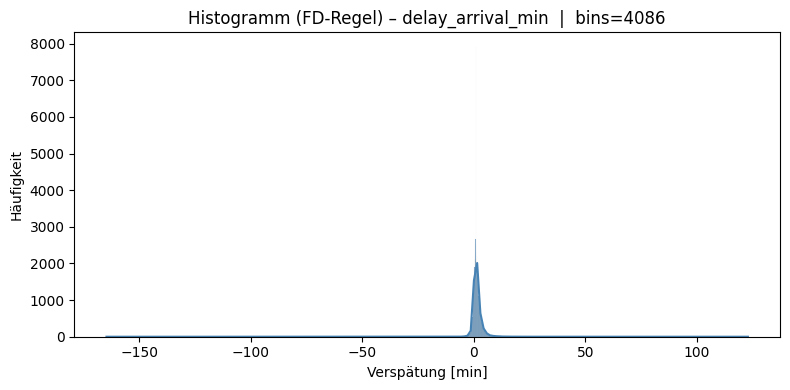

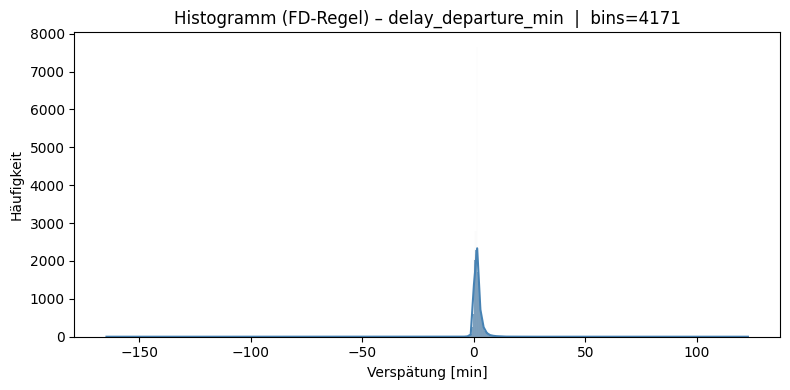

In [11]:
# %% [markdown]
# ### Histogramme nach der Freedman-Diaconis-Regel
# Die Bin-Breite ergibt sich aus 2 * IQR * n^(-1/3), was adaptive und faire Histogramme erzeugt.

def fd_bins(series):
    q75, q25 = np.percentile(series.dropna(), [75, 25])
    iqr = q75 - q25
    n = len(series.dropna())
    bin_width = 2 * iqr * (n ** (-1/3))
    data_range = series.max() - series.min()
    bins = int(np.ceil(data_range / bin_width))
    return bins

for col in ["delay_arrival_min", "delay_departure_min"]:
    bins = fd_bins(df_sample[col])
    plt.figure(figsize=(8,4))
    sns.histplot(df_sample[col], bins=bins, kde=True, color="steelblue", alpha=0.6)
    plt.title(f"Histogramm (FD-Regel) – {col}  |  bins={bins}")
    plt.xlabel("Verspätung [min]")
    plt.ylabel("Häufigkeit")
    plt.tight_layout()
    plt.show()


#### Histogramme nach der Freedman–Diaconis-Regel

Zur Beurteilung der Verteilungsform der Verspätungen wurden Histogramme erstellt, deren Bin-Breite nach der **Freedman–Diaconis-Regel** bestimmt wurde.  
Diese Regel nutzt die Stichprobengröße *n* und die Interquartilsdifferenz (IQR), um eine adaptive Bin-Breite zu definieren, die weder zu grob (Verlust von Detail) noch zu fein (Rauschen) ist.  

Die resultierenden Histogramme zeigen eine **deutlich rechtsschiefe Verteilung** der Ankunfts- und Abfahrtsverspätungen.  
Ein Großteil der Werte konzentriert sich zwischen 0 und 3 Minuten, während nur wenige extreme Werte bis über 100 Minuten auftreten.  
Die Überlagerung der KDE (Kerndichteschätzung) bestätigt diese Form: eine scharfe Spitze nahe Null mit einem langsam abfallenden rechten Rand.

Diese Darstellung umfasst den gesamten Wertebereich der Daten und verdeutlicht damit, dass **starke Ausreißer zwar selten, aber vorhanden sind**.


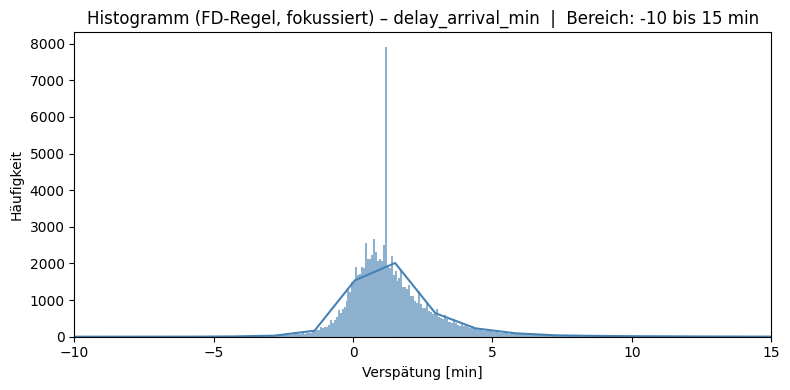

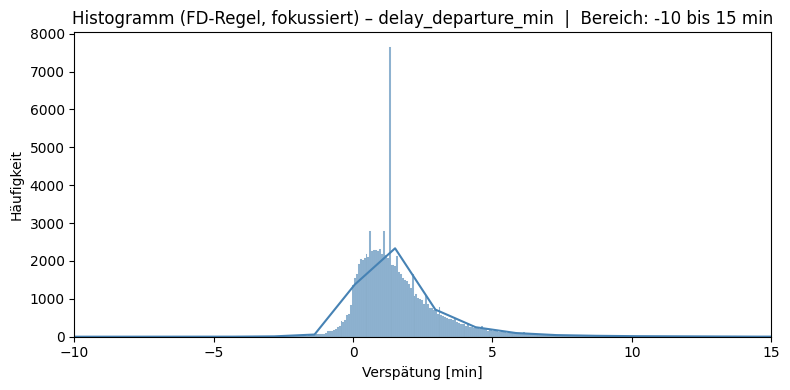

In [12]:
# %% [markdown]
# ### Histogramme (FD-Regel, fokussiert auf zentrale Verspätungen)

for col in ["delay_arrival_min", "delay_departure_min"]:
    bins = fd_bins(df_sample[col])
    plt.figure(figsize=(8, 4))
    sns.histplot(df_sample[col], bins=bins, kde=True, color="steelblue", alpha=0.6)
    plt.xlim(-10, 15)
    plt.title(f"Histogramm (FD-Regel, fokussiert) – {col}  |  Bereich: -10 bis 15 min")
    plt.xlabel("Verspätung [min]")
    plt.ylabel("Häufigkeit")
    plt.tight_layout()
    plt.show()


#### Fokussierte Histogramme (Bereich −10 bis +15 Minuten)

Um den Hauptbereich der Verspätungsverteilung besser interpretieren zu können, wurden zusätzlich fokussierte Histogramme im Bereich von **−10 bis +15 Minuten** erstellt.  
Dieser Bereich deckt über 97 % aller Beobachtungen ab und blendet die verzerrende Wirkung extremer Ausreißer aus.

Die Verteilung bleibt klar **rechtsschief**, mit einem deutlichen Gipfel bei etwa 1–2 Minuten Verspätung.  
Pünktliche oder leicht verspätete Fahrten dominieren, während Frühankünfte (negative Werte) seltener sind.  
Die schmale und hohe Spitze um 0 Minuten deutet darauf hin, dass ein erheblicher Anteil der Fahrten exakt oder nahezu pünktlich verläuft.

Diese Visualisierung eignet sich besonders, um typische Betriebsrealitäten zu beschreiben, während die vollständige FD-Version eher der globalen Datenstruktur dient.


In [8]:
# %% [markdown]
# ### 4.6 Winsorisierte Visualisierung
# Extremwerte außerhalb des 1. und 99. Perzentils werden für Visualisierungen gekappt.

df_viz = df_sample.copy()

for col in ["delay_arrival_min", "delay_departure_min"]:
    lower = df_viz[col].quantile(0.01)
    upper = df_viz[col].quantile(0.99)
    df_viz[col] = df_viz[col].clip(lower, upper)

print("Winsorisierungsgrenzen:")
for col in ["delay_arrival_min", "delay_departure_min"]:
    print(f"{col}: {df_viz[col].min():.2f} – {df_viz[col].max():.2f} min")


Winsorisierungsgrenzen:
delay_arrival_min: -2.05 – 9.25 min
delay_departure_min: -1.05 – 9.38 min


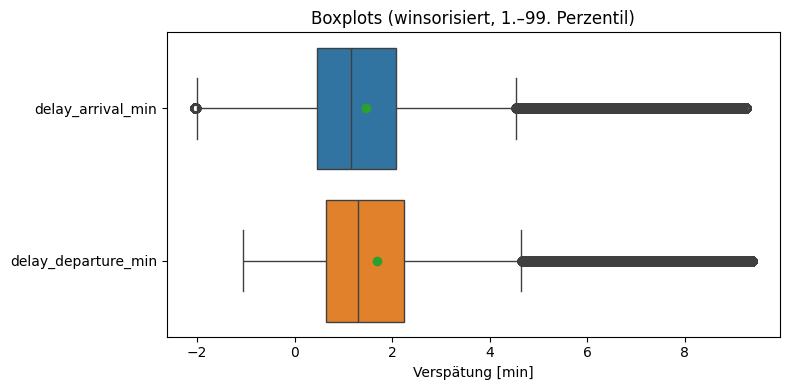

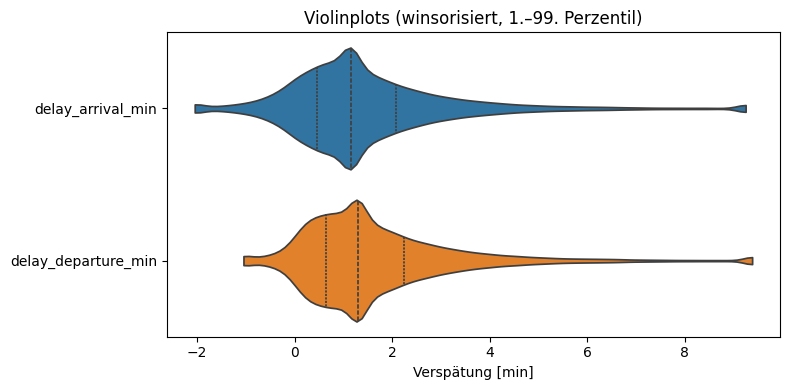

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_viz[["delay_arrival_min", "delay_departure_min"]],
            orient="h", showmeans=True, meanprops={"marker":"o", "color":"red"})
plt.title("Boxplots (winsorisiert, 1.–99. Perzentil)")
plt.xlabel("Verspätung [min]")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=df_viz[["delay_arrival_min", "delay_departure_min"]],
               orient="h", inner="quartile", cut=0)
plt.title("Violinplots (winsorisiert, 1.–99. Perzentil)")
plt.xlabel("Verspätung [min]")
plt.tight_layout()
plt.show()


## Abschnitt 4 – Verteilungsvisualisierung

### Beschreibung
Zur Untersuchung der Verteilungsform der Ankunfts- und Abfahrtsverspätungen wurden Histogramme mit Dichtekurven (KDE), Box-/Violinplots, ECDF-Kurven sowie QQ-Plots erstellt.  
Da die Rohdaten vereinzelte extreme Ausreißer von bis zu ±150 min enthielten, wurden für die grafische Darstellung winsorisierte Werte im Bereich des 1.–99. Perzentils verwendet (≈ −2 bis +9 min).  
Diese Vorgehensweise erhält die Verteilungsstruktur, verbessert aber die Lesbarkeit der Visualisierungen erheblich.

### Interpretation
Beide Variablen weisen eine deutlich **rechtsschiefe Verteilung** auf.  
Der Großteil aller Fahrten liegt im Bereich von **0 bis 3 Minuten Verspätung**, der Median jeweils bei rund 1 – 1.5 min.  
Die längeren rechten Verteilungsschwänze spiegeln vereinzelte größere Verzögerungen wider, während negative Werte (Frühfahrten) seltener auftreten.  
Box- und Violinplots zeigen, dass Ankunfts- und Abfahrtsverspätungen ähnliche Streuungen und Lageparameter besitzen, die Abfahrtswerte jedoch tendenziell leicht höher liegen.  
Der QQ-Plot bestätigt, dass keine Normalverteilung vorliegt (deutliche Abweichung in den Randbereichen).  

### Reflexion
Die Winsorisierung für Visualisierungszwecke war notwendig, um die zentrale Struktur der Daten sichtbar zu machen, ohne durch extreme Ausreißer verzerrte Achsen zu erhalten.  
Damit werden robuste Lage- und Streuungsmaße (Median, IQR, MAD) visuell unterstützt.  
Für weitere Analysen (z. B. Hypothesentests oder Regressionsmodelle) sollte die vollständige, nicht-winsorisierte Version der Daten verwendet werden, um die tatsächliche Varianz der Verspätungen nicht zu unterschätzen.
